In [1]:
import numpy as np
import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file)

sys.path.append(join(dir_path, "HelperFiles"))
import helper
import retrospective
import top_k 
import train_models
import load_data 

from os.path import join
data_path = join(dir_path, "Experiments", "Data")

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import binom
import importlib

In [2]:
# dataset = "census" #breast_cancer
# X_train, y_train, X_test, y_test, mapping_dict = load_data.load_data(data_path, dataset)
# model = train_models.train_model(X_train, y_train, "nn", lime=False)

# print("Class imbalance: {}%".format(round(100*(max(np.mean(y_test), 1-np.mean(y_test))))))
# Y_preds = (model(X_test) > 0.5).astype("int")
# print("NN {}% accuracy".format(round(np.mean(Y_preds == y_test)*100)))
# d = len(mapping_dict) if mapping_dict is not None else X_train.shape[1]
# print(d)

# Ongoing runs
## Retrospective rank verification
### Shapley Sampling and KernelSHAP, various alphas. Both always control FWER!

In [127]:
import pickle
results_path = join(dir_path, "Experiments", "Results")
retro_path = join(results_path, "Retrospective")
# fname = "ss_census_shap_vals"
# fname2 = "ss_census_N_verified"
# fname = "kernelshap_census_shap_vals"
# fname2 = "kernelshap_census_N_verified"
method = "ss"
dataset = "census"
with open(join(retro_path, method+"_"+dataset), 'rb') as f:
    retro_results = pickle.load(f)
shap_vals = retro_results["shap_vals"]
N_verified_all = retro_results["N_verified"]
shap_vars = retro_results["shap_vars"]

In [128]:
# Number of stable ranks from retrospective procedure. 
importlib.reload(helper)
alphas = [0.05, 0.1, 0.2]
print("Alphas:\t", alphas)
all_ranks = helper.shap_vals_to_ranks(shap_vals, abs=True)

N_pts, N_runs, N_alphas = N_verified_all.shape
print(N_verified_all.shape)
avg_shap = np.mean(shap_vals, axis=1)
avg_ranks = np.array([helper.get_ranking(avg_shap[i], abs=True) for i in range(N_pts)])
# Ignore input samples on which at most 25% of iterations verify any ranks.
fwers = helper.calc_all_retro_fwers(N_verified_all, all_ranks, avg_ranks, thresh = 0.25)
print("Max:\t", np.round(np.nanmax(fwers, axis=1), 3))
print("Mean:\t", np.round(np.nanmean(fwers, axis=1), 3))


Alphas:	 [0.05, 0.1, 0.2]
(30, 50, 3)
Max:	 [0.02  0.02  0.111]
Mean:	 [0.004 0.008 0.026]


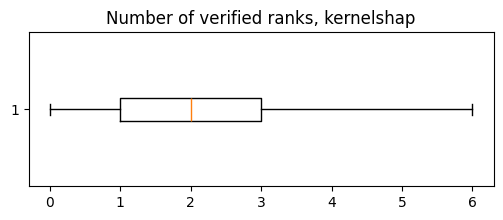

In [110]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.title("Number of verified ranks, " + method)
plt.boxplot(N_verified_all.reshape(-1), vert=False)
plt.show()

# Top-K:
## RankSHAP (from rankshap_vs_ss.py)
- alpha = 0.2: Always controls FWER for K=2 and K=5, didn't let finish, fairly conservative
- alpha = 0.1: Generally good. Didn't let K=5 finish. 1x on each K, get  FWER > alpha, but by a margin that's not unlikely.

In [41]:
alpha = 0.1
top_k_path = join(results_path, "Top_K", "rank", "alpha_" + str(alpha))
K = 5
fname = "rankshap_vs_ss_k" + str(K)

with open(join(top_k_path, fname), 'rb') as f:
    results = pickle.load(f)
top_K_rs = np.array(results['rankshap'])

print(len(top_K_rs))
print(1-binom.cdf(6, 50, .1))
print(1-binom.cdf(7, 50, .1))
print([helper.calc_fwer(top_K, digits=3).item() for top_K in top_K_rs])

22
0.22977315819637745
0.1221450836012784
[0.0, 0.0, 0.0, 0.02, 0.08, 0.04, 0.02, 0.02, 0.14, 0.02, 0.0, 0.06, 0.1, 0.02, 0.02, 0.02, 0.08, 0.0, 0.04, 0.1, 0.0, 0.02]


<!-- ### Weird. Sometimes the allocation blows up, usually no extra at all -->

## RankSHAP, failure cases (skipping)

In [ ]:
alpha = 0.1
top_k_path = join(results_path, "Top_K", "rank", "alpha_" + str(alpha))
K = 2
fname = "rankshap_census_K" + str(K)

with open(join(top_k_path, fname), 'rb') as f:
    results = pickle.load(f)
# top_K_rs = np.array(results['shap_vals'])
fwers = results['fwers']
# array = np.array([value for value in fwers.values()])


# print(len(top_K_rs))
# print(1-binom.cdf(6, 50, .1))
# print(1-binom.cdf(7, 50, .1))
# print([helper.calc_fwer(top_K, digits=3).item() for top_K in top_K_rs])

TypeError: iteration over a 0-d array